
# Реализация MLP с регуляризациями на NumPy

В этом ноутбуке реализована нейросеть (MLP) с использованием библиотеки NumPy. Мы поддерживаем L1, L2 регуляризации и Dropout


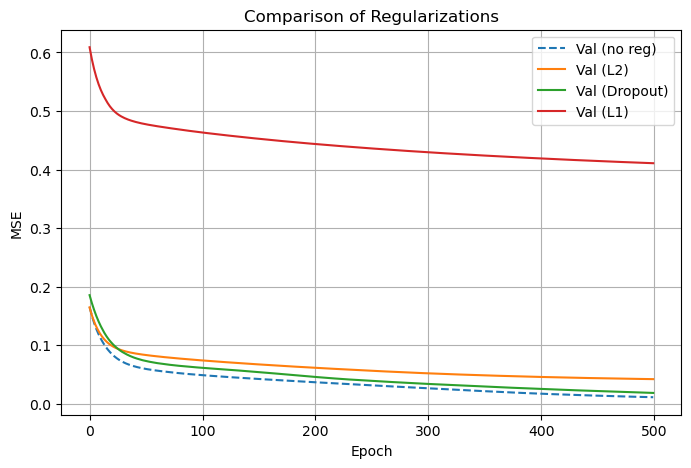

In [ ]:
# MLP с регуляризациями на NumPy

# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)  # Для воспроизводимости результатов

# Класс MLP
class MLP:
    # Настройка архитектуры модели (веса, слои, гиперпаметры)
    def __init__(self, layer_sizes, activation='relu', lr=0.01, l2=0.0, l1=0.0, dropout=0.0):
        # layer_sizes: структура слоев, напр. [1(входной), 64(скрытый), 64(скрытый), 1(выходной)]
        # Сохранение параметров внутри класса, чтобы к ним можно было обращаться
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.lr = lr  # Скорость обучения
        self.l2 = l2  # L2 регуляризация
        self.l1 = l1  # L1 регуляризация
        self.dropout = dropout  # Dropout регуляризация

        # Списки для весов (W), смещений (b)
        self.W, self.b = [], []
        self.masks = [None] * (len(layer_sizes) - 2)  # маски дропаутов только для скрытых слоев

        for i in range(len(layer_sizes) - 1):
            in_dim, out_dim = layer_sizes[i], layer_sizes[i+1] # Достает размеры входа и выхода слоев
            self.W.append(np.random.randn(in_dim, out_dim) * np.sqrt(2/(in_dim + out_dim))) # Создаем матрицу для слоя
            # np.sqrt(2/(in_dim + out_dim) - чтобы веса были стабиль
            self.b.append(np.zeros((1, out_dim))) # Добавляет вектор смещения с нулями

    def _activate(self, Z):
        # Функция активации
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-Z)) # Сжимает значения от 0 до 1, для вероятностей
        elif self.activation == 'relu':
            return np.maximum(0, Z) # Обнуляет отрицательные значения, ускоряет обучение
        elif self.activation == 'tanh':
            return np.tanh(Z) # от -1 до 1, "центрированная" сигмоида, гладкая

    def _dactivate(self, Z):
        # Производные для обратного прохода
        if self.activation == 'sigmoid':
            s = 1 / (1 + np.exp(-Z)) 
            return s * (1 - s) # Производная сигмоиды: σ(z) * (1 - σ(z))
        elif self.activation == 'relu':
            return (Z > 0).astype(float) # Производная ReLU: 1 для Z > 0, иначе 0
        elif self.activation == 'tanh':
            return 1 - np.tanh(Z)**2 # Производная tanh: 1 - tanh(Z)^2

    def forward(self, X, train=True):
        # Прямой проход
        self.Z_list, self.A_list = [], []
        A = X; self.A_list.append(A) # Начальные данные — это вход
        for i in range(len(self.W)):
            Z = A.dot(self.W[i]) + self.b[i]; self.Z_list.append(Z)
            A = self._activate(Z) if i < len(self.W)-1 else Z # Активация (кроме последнего слоя)
            # Применяем Dropout во время обучения на скрытых слоях
            if train and self.dropout > 0 and i < len(self.W)-1:
                mask = (np.random.rand(*A.shape) > self.dropout) / (1 - self.dropout)
                A *= mask
                self.masks[i] = mask
            self.A_list.append(A)
        return A

    def mse(self, y_pred, y_true):
        # MSE + L2 + L1 регуляризация
        loss = np.mean((y_pred - y_true)**2) # Сренднеквадратичная ошибка
        loss += (self.l2/2) * sum(np.sum(W*W) for W in self.W)  # L2, штраф за слишком большие веса
        loss += self.l1 * sum(np.sum(np.abs(W)) for W in self.W)  # L1, штраф за ненулевые веса
        return loss

    def backward(self, y_true):
        # Обратное распространение ошибки
        m = y_true.shape[0]
        aL = self.A_list[-1]  # Последний выход — предсказания модели
        delta = (2 * (aL - y_true)) / m # Производная MSE по выходу модели

        self.dW_list, self.db_list = [], []

        # Идем по слоям в обратном порядке (от конца к началу)
        for l in reversed(range(len(self.W))):
            a_prev = self.A_list[l]
            z = self.Z_list[l] if l < len(self.Z_list) else None # Z на текущем слое (нужно для производной активации)
            # Если это скрытый слой, применяем производную функции активации
            if l < len(self.W)-1:
                delta *= self._dactivate(z)
                # Применяем дропаут, если он включен (обнуляем градиенты для выкинутых нейронов)
                if self.dropout > 0:
                    delta *= self.masks[l]

            dW = a_prev.T.dot(delta) + self.l2 * self.W[l] + self.l1 * np.sign(self.W[l])
            db = np.sum(delta, axis=0, keepdims=True)

            # Сохраняем градиенты в начало списка (чтобы сохранить прямой порядок)
            self.dW_list.insert(0, dW)
            self.db_list.insert(0, db)

            delta = delta.dot(self.W[l].T)

    def update_params(self):
        # Обновление весов
        for i in range(len(self.W)):
            self.W[i] -= self.lr * self.dW_list[i]
            self.b[i] -= self.lr * self.db_list[i]


# Функция обучения
X_train = np.linspace(-1, 1, 100).reshape(-1, 1)
y_train = X_train**2 + np.random.randn(*X_train.shape) * 0.1
X_val = np.linspace(-1, 1, 100).reshape(-1, 1)
y_val = X_val**2

def train_model(model, epochs=500):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        preds = model.forward(X_train, train=True) # прямой проход
        train_losses.append(model.mse(preds, y_train)) # ошибка
        model.backward(y_train)  # обратный проход
        model.update_params() # обновление весов
        preds_val = model.forward(X_val, train=False) # прогон на валидации
        val_losses.append(model.mse(preds_val, y_val)) # ошибка на валидации
    return train_losses, val_losses

# Модели для сравнения
m0 = MLP([1,64,64,1], lr=0.01, l2=0.00, l1=0,    dropout=0.0)
m1 = MLP([1,64,64,1], lr=0.01, l2=0.001, l1=0,    dropout=0.0)
m2 = MLP([1,64,64,1], lr=0.01, l2=0.00, l1=0,    dropout=0.1)
m3 = MLP([1,64,64,1], lr=0.01, l2=0.00, l1=0.001, dropout=0.0)

l0, v0 = train_model(m0)
l1, v1 = train_model(m1)
l2, v2 = train_model(m2)
l3, v3 = train_model(m3)

# График
plt.figure(figsize=(8,5))
plt.plot(v0, '--', label='Val (no reg)')
plt.plot(v1, label='Val (L2)')
plt.plot(v2, label='Val (Dropout)')
plt.plot(v3, label='Val (L1)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Comparison of Regularizations')
plt.grid(True)
plt.legend()
plt.show()



## Объяснение структуры класса MLP

- `__init__`: инициализирует структуру сети, веса, смещения и параметры регуляризации.
- `_activate` и `_dactivate`: функции активации и их производные.
- `forward`: прямой проход по слоям, применяет активации и Dropout.
- `mse`: вычисляет ошибку и добавляет L1 и L2 штраф.
- `backward`: обратное распространение ошибки с учетом L1, L2, Dropout.
- `update_params`: обновление весов с помощью градиентов.

---

## Версия в процедурном стиле

Иногда ООП может быть сложнее для понимания, особенно в начале. Вот процедурная альтернатива:


In [ ]:

# Пример процедурного (не-ООП) прямого прохода
def init_weights(input_dim, hidden1, hidden2, output_dim):
    W1 = np.random.randn(input_dim, hidden1) * np.sqrt(2/(input_dim + hidden1))
    b1 = np.zeros((1, hidden1))
    W2 = np.random.randn(hidden1, hidden2) * np.sqrt(2/(hidden1 + hidden2))
    b2 = np.zeros((1, hidden2))
    W3 = np.random.randn(hidden2, output_dim) * np.sqrt(2/(hidden2 + output_dim))
    b3 = np.zeros((1, output_dim))
    return W1, b1, W2, b2, W3, b3

def relu(x): return np.maximum(0, x)
def forward_pass(X, W1, b1, W2, b2, W3, b3):
    z1 = X @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    a2 = relu(z2)
    z3 = a2 @ W3 + b3
    return z3
